In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys

In [2]:
train = pd.read_csv('data/train.tsv', sep='\t')
test = pd.read_csv('data/test.tsv', sep='\t')

df = pd.concat([train, test], axis=0)

# removing cars with year of production less than 1900
train = train[train['Godina proizvodnje'] >= 1900]
# train = train[train['Cena'] <= 50000]

print(train.shape)

#removing duplicates
train.drop_duplicates(inplace=True)
train.reset_index(drop=True, inplace=True)

print(train.shape)

(993, 10)
(951, 10)


In [3]:
numerical_columns = df.select_dtypes(exclude=object).columns.tolist()

nominal = {
    'Karoserija': df['Karoserija'].unique(),
    'Gorivo': df['Gorivo'].unique(),
    # 'Grad': df['Grad'].unique(),
    'Marka': df['Marka'].unique()
}

def encode(binary, nominal=nominal):
    # label encoding for binary
    for col in binary:
        train[col] = train[col].map({'Manuelni': 0, 'Automatski': 1})
        test[col] = test[col].map({'Manuelni': 0, 'Automatski': 1})
    # one hot encoding for nominal
    for col in nominal:
        for category in nominal[col]:
            train[category] = (train[col] == category).astype(int)
            test[category] = (test[col] == category).astype(int)
        train.drop(col, axis=1, inplace=True)
        test.drop(col, axis=1, inplace=True)

    return train, test

train, test = encode(['Menjac'])

# categorical_columns = train.select_dtypes(include=object).columns.tolist()

# for column in categorical_columns:
#     train[column] = pd.factorize(train[column])[0]
# for column in categorical_columns:
#     test[column] = pd.factorize(test[column])[0]

for column in numerical_columns:        
    mean = train[column].mean()
    std = train[column].std()
    if column == 'Cena':
        continue
    train[column] = (train[column] - mean) / std
    test[column] = (test[column] - mean) / std

In [4]:
# mean_price, std_price = 0, 0

# def normalize_features(num_vars):
#     for col in num_vars:            
#         mean = train[col].mean()
#         std = train[col].std()
#         if col == 'Cena':
#             global mean_price, std_price
#             mean_price, std_price = mean, std
#         train[col] = (train[col] - mean) / std
#         test[col] = (test[col] - mean) / std

#     return train, test

# train, test = normalize_features(['Godina proizvodnje', 'Zapremina motora', 'Kilometraza', 'Konjske snage', 'Cena'])

In [5]:
def fit(x_train, y_train, LR=0.01, ALPHA=0.9, EPOCHS=9000):
    # Lasso
    rows, columns = x_train.shape
    coefficients = np.zeros(columns)
    for _ in range(EPOCHS):
        y_pred = np.dot(x_train, coefficients)
        error = y_pred - y_train
        gradients = (1 / rows) * np.dot(x_train.T, error) + ALPHA * np.sign(coefficients)
        coefficients -= LR * gradients
    return coefficients


def predict__coeff(x_test, coefficients):
    return np.dot(x_test, coefficients)

def calculate_rmse(y_true, y_pred):
    residuals = y_true - y_pred
    squared_residuals = residuals ** 2
    mean_squared_residuals = squared_residuals.mean()
    rmse = np.sqrt(mean_squared_residuals)
    return rmse

In [6]:
class KNNRegressor:
    def __init__(self, k, dist):
        self.k = k
        self.distance = dist
        self.X_train = []
        self.y_train = []

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def predict(self, X_test):
        predictions = []
        for sample in X_test:
            distances = np.array([self.distance(sample, x) for x in self.X_train])
            nearest_indices = np.argsort(distances)[:self.k]
            nearest_labels = [self.y_train[i] for i in nearest_indices] 
            prediction = np.mean(nearest_labels)
            predictions.append(prediction)
        return np.array(predictions)
    
    @staticmethod
    def euclidean_distance(x, y):
        sum_squared_diff = 0.0

        for i in range(len(x)):
            sum_squared_diff += (x[i] - y[i]) ** 2

        return sum_squared_diff ** 0.5
    

In [7]:
def loss(y,y_predicted):
    n=len(y)
    s=0
    for i in range(n):
        s+=(y[i]-y_predicted[i])**2
    return (1/n)*s

def fit_with_regularization(X, y, learning_rate=0.1, max_iterations=10000, lambda_=0.1):
    weights = np.zeros(X.shape[1])
    bias = 0
    loss = []

    for _ in range(max_iterations):
        y_hat = np.dot(X, weights) + bias
        loss.append(calculate_rmse(y, y_hat))

        partial_w = (1 / X.shape[0]) * (2 * np.dot(X.T, (y_hat - y)))
        partial_b = (1 / X.shape[0]) * (2 * np.sum(y_hat - y))

        # L1 regularization
        regularization_term = lambda_ * weights
        partial_w += regularization_term

        weights -= learning_rate * partial_w
        bias -= learning_rate * partial_b

    return weights, bias, loss

def predict_bias(X, w, bias):
    return np.dot(X, w) + bias

class LinearRegression:
  
  ## Set the learning rate and number of iterations
  def __init__(self,learning_rate=0.01,n_iters=1000, lambda_=0.1):
    # initialize learning rate lr and number of iteration iters
    self.lr=learning_rate
    self.iters=n_iters
    self.lambda_=lambda_
    # initialize the weights matrix
    self.weights=None
    
  def fit(self,X,y):
    n_samples=len(X)
    # modify x, add 1 column with value 1
    ones=np.ones(len(X))
    features=np.c_[ones,X]
    # initialize the weights matrix
    self.weights = np.zeros(features.shape[1])

    for i in range(self.iters):
      # predicted labels
      y_predicted=np.dot(features,self.weights.T)
      # calculate the error
      error=y_predicted-y
      # compute the partial derivated of the cost function
      dw = (2 / n_samples) * np.dot(features.T,error)
      # update the weights matrix
      regularization_term = (self.lambda_ / n_samples) * np.sign(self.weights)
# Update the weights matrix with regularization
      self.weights -= self.lr * (dw + regularization_term)
       
  def predict(self,X):
    ones=np.ones(len(X))
    features=np.c_[ones,X]
    # predict the labels matrix
    y_predicted=np.dot(features,self.weights.T)
    return y_predicted

In [8]:
y_train = train['Cena']
X_train = train.drop(columns= ['Cena', 'Grad'], axis=1)
y_test = test['Cena']
X_test = test.drop(columns= ['Cena', 'Grad'], axis=1)

In [9]:
coeff = fit(X_train, y_train)
y_pred = predict__coeff(X_test, coeff)

print(calculate_rmse(y_test, y_pred))


186574.10957505397


In [10]:

# for i in range(1, 30):
#     knn = KNNRegressor(k=i, dist=KNNRegressor.euclidean_distance)
#     knn.fit(X_train.values, y_train.values)
#     y_pred = knn.predict(X_test.values)
#     print(f' k={i}: {calculate_rmse(y_test, y_pred)}')

188033.4723843295


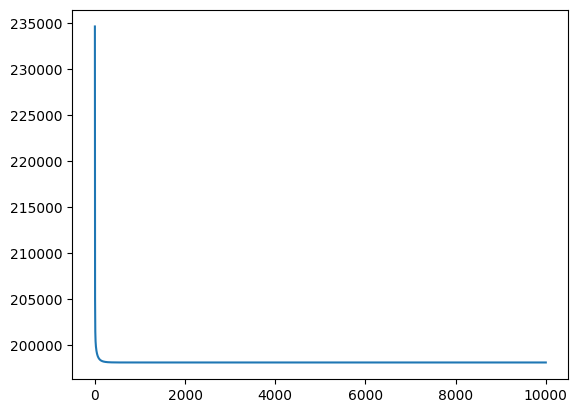

190402.2176286644


In [11]:
w, b, loss = fit_with_regularization(X_train, y_train)
y_pred = predict_bias(X_test, w, b)

print(calculate_rmse(y_test, y_pred))

plt.plot(range(len(loss)), loss)
plt.show()

c=LinearRegression(learning_rate=0.0001, n_iters=20000)
c.fit(X_train, y_train)
y_pred=c.predict(X_test)

print(calculate_rmse(y_test, y_pred))